In [1]:
from pandas_datareader import DataReader
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
def GARCH(Y):
 "Initialize Params:"
 mu = param0[0]
 omega = param0[1]
 alpha = param0[2]
 beta = param0[3]
 T = Y.shape[0]
 GARCH_Dens = np.zeros(T) 
 sigma2 = np.zeros(T)   
 F = np.zeros(T)   
 v = np.zeros(T)   
 for t in range(1,T):
    sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
    F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
    v[t] = sigma2[t]
    GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+\
                    (1/2)*(F[t]/v[t])     
    Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [3]:
def GARCH_PROD(params, Y0, T):
 mu = params[0]
 omega = params[1]
 alpha = params[2]
 beta = params[3]
 Y = np.zeros(T)  
 sigma2 = np.zeros(T)
 Y[0] = Y0
 sigma2[0] = 0.0001
 for t in range(1,T):
    sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
    Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
 return Y  

In [4]:
# Ten year data for P&G:
PG = DataReader('PG',  'yahoo', datetime(2019,1,1), datetime(2019,12,31));

# Avergae of opening and closing:
avg = list()
for i in range(len(PG)):
    avg = (PG["Open"] + 2 * PG["High"] +PG["Close"])/4
PG["Average"] = avg

# Required Dataset: 
PG.head()

,High,Low,Open,Close,Volume,Adj Close,Average
Date,,,,,,,
2019-01-02,91.389999,89.930000,91.029999,91.279999,9843900.0,88.258690,91.272499
2019-01-03,92.500000,90.379997,90.940002,90.639999,9820200.0,87.639870,91.645000
2019-01-04,92.489998,90.370003,90.839996,92.489998,10565700.0,89.428635,92.077497
2019-01-07,92.500000,91.400002,91.910004,92.120003,9012500.0,89.070892,92.257502
2019-01-08,93.089996,91.820000,92.699997,92.459999,9551300.0,89.399635,92.834997


Divide-by-zero encountered: rhok assumed large
         Current function value: -120.686091
         Iterations: 5
         Function evaluations: 279
         Gradient evaluations: 44


C:\Users\parth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys
C:\Users\parth\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


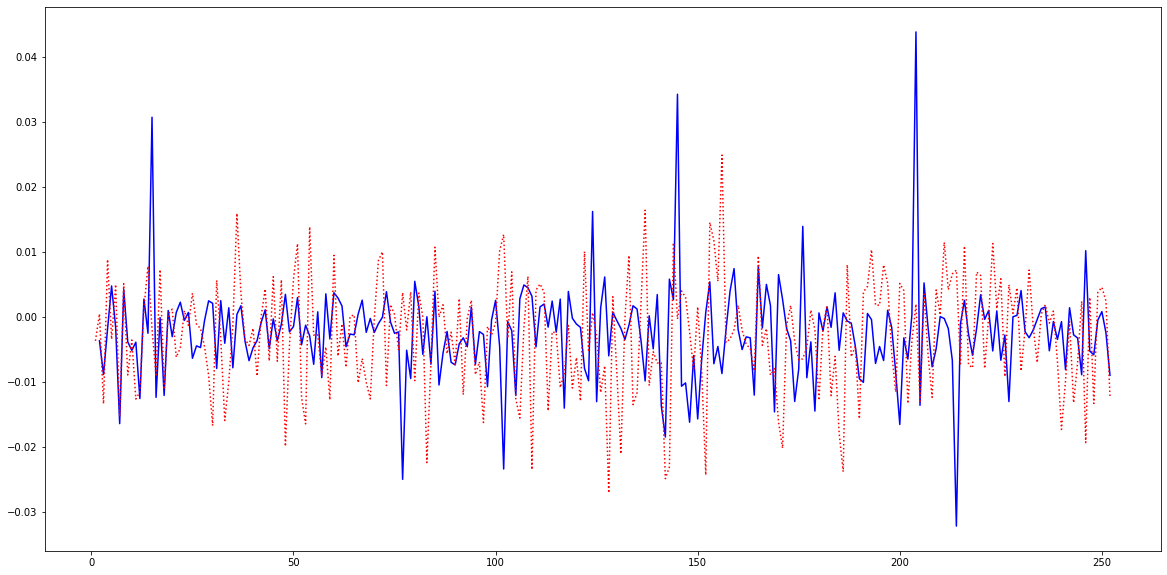

In [5]:
T=PG.shape[0]
PG['log_return'] = np.log(PG['Open'] / PG['Average'].shift(periods=1))
mu = PG['log_return'].mean()
omega = PG['log_return'].var()
Y = PG['log_return']
param0 = np.array([mu, omega, 0.09, 0.05])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-16, 'disp': True})
Y_GARCH = GARCH_PROD(param_star.x, Y[1], T)
timevec = np.linspace(1,T,T)
plt.figure(figsize=(20,10))
plt.plot(timevec, Y,'b',timevec, Y_GARCH,'r:')

In [6]:
Y_dash = np.exp(Y_GARCH) * PG['Average'].shift(periods=1)
mean_error = np.mean(Y_dash - PG['Open'])
rms = sqrt(mean_squared_error(PG['Open'], Y_dash.fillna(0)))

In [7]:
rms

5.874461332006167

In [9]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=timevec,
                open=PG['Open'],
                high=PG['High'],
                low=PG['Low'],
                close=PG['Close'])])

fig.add_trace(
    go.Scatter(
        x=timevec,
        y=Y_dash
    ))

fig.show()